#### Stage 1
# Flow Data - Temporal Overview
with matplotlib

##### Generating Temporal Plots
This notebook includes the code for **visualizations 2, 3 and 4**.
It uses the *matplotlib* package to generate the plots for visualizations **3 and 4** from **cycledf.csv**.
**Visualization 2** is generated using the heatmap-function from the *seaborn* package.
Separate functions are written for the horizontal and the circular versions of visualizations **3 and 4** and a third function to choose between the two, depending on the chosen parameters.
Within the plotting functions, the datasets are filtered and aggregated according to the chosen filter options.

This notebook furthermore incorporates the following changes proposed during the user test:

##### Heatmap (**visualization number 2**)
The choice between a dark and a light colour scheme can now be made interactively.
A dark background as it would appear in a dark interface has been added.

##### Radial Bar Chart (**visualization 4**)
A small pie chart was added in the middle of the plot, its area representing the total number of movements durng the plotted day. It is divided and coloured according to the parts that movements of the different modes occupy.
The area of the pie chart depends on the total number with the highest possible number taking up all free space in the middle of the chart.
The maximum number of movements is now plotted at the bar corresponding to that maximum.
The total number of movements is plotted next to the maximum number in the colour corresponding to the plotted modes.
When plotting both the public and private modes, it can be chosen that those are split similarly to the horizontal version.
To keep the visually perceived quantity for both modes as equal as possible, the bars are reduced to half their width, starting at a common ground.
It has to be kept in mind, that even though the bars now visually only span half an hour, they still represent values for the full hour.

##### Versions of the used packages:
- pandas: 0.24.2
- numpy: 1.16.4
- matplotlib: 3.2.1
- seaborn: 0.9.0
- ipywidgets: 7.5.1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import ipywidgets as pyw

In [2]:
def csvtodf_SC(path):
    data = pd.read_csv('data/'+path+'.csv',
                       delimiter=';',
                       skipinitialspace=True,
                       skiprows=0)
    df = pd.DataFrame(data)
    return df;

def csvtodf_C(path):
    data = pd.read_csv('data/'+path+'.csv',
                       delimiter=',',
                       skipinitialspace=True,
                       skiprows=0)
    df = pd.DataFrame(data)
    return df;

## load data
processed in 24.0

In [3]:
cycledf = csvtodf_SC('cycledf')
cycledf.head()

,flowID,flowIdDir,from_cell,to_cell,dayInt,weekday,dayType,hour,moves,privat,public,Rail,UBahn,Tram,Bus
0,100_101,-1,101,100,0,Monday,MonThu,4,1,1.0,0.0,0.0,0.0,0.0,0.0
1,100_101,-1,101,100,0,Monday,MonThu,15,1,1.0,0.0,0.0,0.0,0.0,0.0
2,100_101,-1,101,100,1,Tuesday,MonThu,4,1,1.0,0.0,0.0,0.0,0.0,0.0
3,100_101,-1,101,100,1,Tuesday,MonThu,5,1,1.0,0.0,0.0,0.0,0.0,0.0
4,100_101,-1,101,100,1,Tuesday,MonThu,6,1,1.0,0.0,0.0,0.0,0.0,0.0


## set constant parameters

In [4]:
days = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dayTypes = ['', 'MonThu', 'Fri', 'Weekend']

modes = ['moves', 'privat', 'public', 'Rail', 'UBahn', 'Tram', 'Bus']
modesPlt = ['', 'privat', 'public']
# meanModes = ['']*7
# for i in range(0,7):
#     meanModes[i] = 'mean'+modes[i]

modesColor = {'privat':'#BFBFBF',#'#999999',
              'Rail':'#4daf4a',
              'UBahn':'#377eb8',
              'Tram':'#e41a1c',
              'Bus':'#984ea3',
              'public':'#ff7f00', # '#ff7f00',
              'moves':'#a65628'} # '#FFFFFF'}
# including ColorBrewer Colors from: https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=9

d = {}
modesAggMean = dict((key, ['mean']) for key in modes)
modesAggSum = dict((key, ['sum']) for key in modes)

hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
ticks = hours.copy()
for i in range(0,24):
    ticks[i] = hours[i]*(360/24)*pi/180

# for horizontal plotting:
def moveMidnight2List(lst):
    lst.append(lst.pop(0))
    lst.append(lst.pop(0))
    return lst;
hours = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 1, 2]
ticksPos = [-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5,20.5,21.5,22.5,23.5]

weekangles = [0]*7
for i in range(0,7):
    weekangles[i] = (i*360/7)*pi/180

## plotting function for circular plot

In [5]:
def plotDayStackedCircular(day='', dayType='', modesPlt=''):
    
    # aggregate cycledf according to filter choices for day and dayType, mean over days and dayTypes for each flowID and direction
    d.update(modesAggMean)
    if (day):
        plotdf = cycledf[(cycledf.weekday == day)].groupby(['flowID', 'flowIdDir', 'hour']).agg(d).copy().reset_index()
        plotdf.columns = plotdf.columns.get_level_values(0)
    elif (dayType):
        plotdf = cycledf[(cycledf.dayType == dayType)].groupby(['flowID', 'flowIdDir', 'hour']).agg(d).copy().reset_index()
        plotdf.columns = plotdf.columns.get_level_values(0)
    else:
        plotdf = cycledf.groupby(['flowID', 'flowIdDir', 'hour']).agg(d).copy().reset_index()
        plotdf.columns = plotdf.columns.get_level_values(0)
    
    # sum over flowIDs and flowIDdir
    d.update(modesAggSum)
    plotdf = plotdf.groupby(['hour']).agg(d).copy().reset_index()
    plotdf.columns = plotdf.columns.get_level_values(0)
    
    # compute total amount of moves
    totalMoves = plotdf.moves.sum()
    totalPrivat = plotdf.privat.sum()
    totalPublic = plotdf.public.sum()
    anglePublic = (360/totalMoves)*totalPublic*pi/180
    totalRail = plotdf.Rail.sum()
    angleRail = (360/totalMoves)*totalRail*pi/180
    totalBus = plotdf.Bus.sum()
    angleBus = (360/totalMoves)*totalBus*pi/180
    totalUBahn = plotdf.UBahn.sum()
    angleUBahn = (360/totalMoves)*totalUBahn*pi/180
    totalTram = plotdf.Tram.sum()
    angleTram = (360/totalMoves)*totalTram*pi/180

    # initialize plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_offset(-pi)
    ax.set_rlabel_position(90)
    ax.yaxis.grid(linestyle = (0,(1,5)))
    ax.spines['polar'].set_visible(False)
    
    angles = list(plotdf.hour*(360/24)*pi/180+(pi/24))
    categories=list(plotdf.hour)
    plt.xticks(ticks, categories, color='grey', size=8)
    
    width=pi/13
    alpha=1 
    
    values = []
    if (modesPlt == 'privat'):
        values = list(plotdf.privat)
        # meanValues = np.mean(values) if values else 0
        maxValues = max(values) if values else 0
        base = .6*maxValues
        maxColor = '#777777'
        totalType = totalPrivat
        # change position to max hour
        ax.set_rlabel_position((plotdf.iloc[plotdf['privat'].idxmax()].hour+0.5)*(360/24))
    elif (modesPlt == 'public'):
        values0 = [0]*24
        maxColor = modesColor['public']
        totalType = totalPublic
        # change position to max hour
        ax.set_rlabel_position((plotdf.iloc[plotdf['public'].idxmax()].hour+0.5)*(360/24))
    else:
        values0 = list(plotdf.privat)
        maxColor = modesColor['moves']
        totalType = totalMoves
        # change position to max hour
        ax.set_rlabel_position((plotdf.iloc[plotdf['moves'].idxmax()].hour+0.5)*(360/24))
    
    if(values): # only plot privates and return
        ax.bar(angles, values, width=width, alpha=alpha, color=modesColor['privat'])
        
        # add piechart in the middle representing the day's total amount of moves
        # circle for moves
        ax.add_artist(plt.Circle((0,0), (base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4), transform=ax.transData._b,
                                 fill=True, color=modesColor['moves'], alpha=1, zorder=20))
        # circle for privates
        ax.add_artist(plt.Circle((0,0), 0.9*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4), transform=ax.transData._b,
                                 fill=True, color=modesColor['privat'], alpha=1, zorder=25))
        # bar for publics
        ax.bar(pi/2, 0.9*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=anglePublic, alpha=alpha, color=modesColor['public'], bottom=-base, zorder=30)
        # bars for public modes
        ax.bar((pi-anglePublic+angleRail)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleRail, alpha=alpha, color=modesColor['Rail'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*angleRail+angleBus)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleBus, alpha=alpha, color=modesColor['Bus'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*(angleRail+angleBus)+angleUBahn)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleUBahn, alpha=alpha, color=modesColor['UBahn'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*(angleRail+angleBus+angleUBahn)+angleTram)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleTram, alpha=alpha, color=modesColor['Tram'], bottom=-base, zorder=35)

        # add maximum circle and labels
        ax.add_artist(plt.Circle((0, 0), maxValues+base, transform=ax.transData._b,
                             fill=False, edgecolor='#777777', linewidth=1, alpha=1, zorder=10))
        ax.set_yticks([1.1*maxValues, maxValues, .75*maxValues, .5*maxValues, .25*maxValues])
        ax.set_yticklabels(['max '+str(int(maxValues/1000))+' Tsd, total '+str(np.round((totalType/1000000),1))+' Mio','','','',''], color=maxColor)
        #ax.set_yticklabels([str(int(maxValues/1000))+' Tsd','','','',''], color='#777777')
        ax.set_rmin(-base)
        # make sure background stays white
        fig.patch.set_facecolor('#FFFFFF')
        return ax;
    
    else: # plot stacked bars, then return    
        values1 = list(plotdf.Rail)
        values2 = list(plotdf.Bus)
        values3 = list(plotdf.UBahn)
        values4 = list(plotdf.Tram)
        values01 = np.add(values0, values1).tolist()
        values012 = np.add(values01, values2).tolist()
        values0123 = np.add(values012, values3).tolist()
        values01234 = np.add(values0123, values4).tolist()

        maxAll = max(values01234) if values01234 else 0
        # meanAll = np.mean(values01234) if values01234 else 0
        base = .6*maxAll

        ax.bar(angles, values0, width=width, alpha=alpha, color=modesColor['privat'])   
        ax.bar(angles, values1, width=width, alpha=alpha, color=modesColor['Rail'], bottom = values0)
        ax.bar(angles, values2, width=width, alpha=alpha, color=modesColor['Bus'], bottom = values01)
        ax.bar(angles, values3, width=width, alpha=alpha, color=modesColor['UBahn'], bottom = values012)
        ax.bar(angles, values4, width=width, alpha=alpha, color=modesColor['Tram'], bottom = values0123)
        
        # add piechart in the middle representing the day's total amount of moves
        # circle for moves
        ax.add_artist(plt.Circle((0,0), (base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4), transform=ax.transData._b,
                                 fill=True, color=modesColor['moves'], alpha=1, zorder=20))
        # circle for privates
        ax.add_artist(plt.Circle((0,0), 0.9*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4), transform=ax.transData._b,
                                 fill=True, color=modesColor['privat'], alpha=1, zorder=25))
        # bar for publics
        ax.bar(pi/2, 0.9*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=anglePublic, alpha=alpha, color=modesColor['public'], bottom=-base, zorder=30)
        # bars for public modes
        ax.bar((pi-anglePublic+angleRail)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleRail, alpha=alpha, color=modesColor['Rail'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*angleRail+angleBus)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleBus, alpha=alpha, color=modesColor['Bus'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*(angleRail+angleBus)+angleUBahn)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleUBahn, alpha=alpha, color=modesColor['UBahn'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*(angleRail+angleBus+angleUBahn)+angleTram)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleTram, alpha=alpha, color=modesColor['Tram'], bottom=-base, zorder=35)

        # add maximum circle and ticklables
        ax.add_artist(plt.Circle((0, 0), maxAll+base, transform=ax.transData._b,
                                 fill=False, edgecolor='#777777', linewidth=1, alpha=1, zorder=10))
        ax.set_yticks([1.1*maxAll, maxAll, .75*maxAll, .5*maxAll, .25*maxAll])
        ax.set_yticklabels(['max '+str(int(maxAll/1000))+' Tsd, total '+str(np.round((totalType/1000000),1))+' Mio','','','',''], color=maxColor)
        ax.set_rmin(-base)
        
        # make sure background stays white
        fig.patch.set_facecolor('#FFFFFF')
        return ax;

version with split bars, half the width:

In [6]:
def plotDayStackedCircularSplit(day='', dayType='', modesPlt=''):
    
    # aggregate cycledf according to filter choices for day and dayType, mean over days and dayTypes for each flowID and direction
    d.update(modesAggMean)
    if (day):
        plotdf = cycledf[(cycledf.weekday == day)].groupby(['flowID', 'flowIdDir', 'hour']).agg(d).copy().reset_index()
        plotdf.columns = plotdf.columns.get_level_values(0)
    elif (dayType):
        plotdf = cycledf[(cycledf.dayType == dayType)].groupby(['flowID', 'flowIdDir', 'hour']).agg(d).copy().reset_index()
        plotdf.columns = plotdf.columns.get_level_values(0)
    else:
        plotdf = cycledf.groupby(['flowID', 'flowIdDir', 'hour']).agg(d).copy().reset_index()
        plotdf.columns = plotdf.columns.get_level_values(0)
    
    # sum over flowIDs and flowIDdir
    d.update(modesAggSum)
    plotdf = plotdf.groupby(['hour']).agg(d).copy().reset_index()
    plotdf.columns = plotdf.columns.get_level_values(0)
    
    # compute total amount of moves
    totalMoves = plotdf.moves.sum()
    totalPrivat = plotdf.privat.sum()
    totalPublic = plotdf.public.sum()
    anglePublic = (360/totalMoves)*totalPublic*pi/180
    totalRail = plotdf.Rail.sum()
    angleRail = (360/totalMoves)*totalRail*pi/180
    totalBus = plotdf.Bus.sum()
    angleBus = (360/totalMoves)*totalBus*pi/180
    totalUBahn = plotdf.UBahn.sum()
    angleUBahn = (360/totalMoves)*totalUBahn*pi/180
    totalTram = plotdf.Tram.sum()
    angleTram = (360/totalMoves)*totalTram*pi/180

    # initialize plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_offset(-pi)
    ax.set_rlabel_position(90)
    ax.yaxis.grid(linestyle = (0,(1,5)))
    ax.spines['polar'].set_visible(False)
    
    angles = list(plotdf.hour*(360/24)*pi/180+(pi/24))
    angles0 = angles.copy()
    categories=list(plotdf.hour)
    plt.xticks(ticks, categories, color='grey', size=8)
    
    width=pi/13
    alpha=1 
    
    values = []
    if (modesPlt == 'privat'):
        values = list(plotdf.privat)
        # meanValues = np.mean(values) if values else 0
        maxValues = max(values) if values else 0
        base = .6*maxValues
        maxColor = '#777777'
        totalType = totalPrivat
        # change position to max hour
        ax.set_rlabel_position((plotdf.iloc[plotdf['privat'].idxmax()].hour+0.5)*(360/24))
    elif (modesPlt == 'public'):
        values0 = [0]*24
        maxColor = modesColor['public']
        totalType = totalPublic
        # change position to max hour
        ax.set_rlabel_position((plotdf.iloc[plotdf['public'].idxmax()].hour+0.5)*(360/24))
    else:
        width = pi/24
        angles0 = list(plotdf.hour*(360/24)*pi/180+(pi/24)-(pi/48))
        angles = list(plotdf.hour*(360/24)*pi/180+(pi/24)+(pi/48))
        values0 = list(plotdf.privat)
        maxColor = modesColor['moves']
        totalType = totalMoves
        # change position to max hour
        ax.set_rlabel_position((plotdf.iloc[plotdf['moves'].idxmax()].hour+0.5)*(360/24))
    
    if(values): # only plot privates and return
        ax.bar(angles, values, width=width, alpha=alpha, color=modesColor['privat'])
        
        # add piechart in the middle representing the day's total amount of moves
        # circle for moves
        ax.add_artist(plt.Circle((0,0), (base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4), transform=ax.transData._b,
                                 fill=True, color=modesColor['moves'], alpha=1, zorder=20))
        # circle for privates
        ax.add_artist(plt.Circle((0,0), 0.9*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4), transform=ax.transData._b,
                                 fill=True, color=modesColor['privat'], alpha=1, zorder=25))
        # bar for publics
        ax.bar(pi/2, 0.9*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=anglePublic, alpha=alpha, color=modesColor['public'], bottom=-base, zorder=30)
        # bars for public modes
        ax.bar((pi-anglePublic+angleRail)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleRail, alpha=alpha, color=modesColor['Rail'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*angleRail+angleBus)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleBus, alpha=alpha, color=modesColor['Bus'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*(angleRail+angleBus)+angleUBahn)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleUBahn, alpha=alpha, color=modesColor['UBahn'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*(angleRail+angleBus+angleUBahn)+angleTram)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleTram, alpha=alpha, color=modesColor['Tram'], bottom=-base, zorder=35)

        # add maximum circle and labels
        ax.add_artist(plt.Circle((0, 0), maxValues+base, transform=ax.transData._b,
                             fill=False, edgecolor='#777777', linewidth=1, alpha=1, zorder=10))
        ax.set_yticks([1.1*maxValues, maxValues, .75*maxValues, .5*maxValues, .25*maxValues])
        ax.set_yticklabels(['max '+str(int(maxValues/1000))+' Tsd, total '+str(np.round((totalType/1000000),1))+' Mio','','','',''], color=maxColor)
        #ax.set_yticklabels([str(int(maxValues/1000))+' Tsd','','','',''], color='#777777')
        ax.set_rmin(-base)
        # make sure background stays white
        fig.patch.set_facecolor('#FFFFFF')
        return ax;
    
    else: # plot stacked bars, then return    
        values1 = list(plotdf.Rail)
        values2 = list(plotdf.Bus)
        values3 = list(plotdf.UBahn)
        values4 = list(plotdf.Tram)
        values01 = np.add(values0, values1).tolist()
        values012 = np.add(values01, values2).tolist()
        values0123 = np.add(values012, values3).tolist()
        values01234 = np.add(values0123, values4).tolist()
        values12 = np.add(values1, values2).tolist()
        values123 = np.add(values12, values3).tolist()
        values1234 = np.add(values123, values4).tolist()

        if (modesPlt):
            maxAll = max(values01234) if values01234 else 0
        else:
            maxAll = max(max(values1234), max(values0)) if (values1234 and values0) else 0
        # meanAll = np.mean(values01234) if values01234 else 0
        base = .6*maxAll

        ax.bar(angles0, values0, width=width, alpha=alpha, color=modesColor['privat'])   
        ax.bar(angles, values1, width=width, alpha=alpha, color=modesColor['Rail'])
        ax.bar(angles, values2, width=width, alpha=alpha, color=modesColor['Bus'], bottom = values1)
        ax.bar(angles, values3, width=width, alpha=alpha, color=modesColor['UBahn'], bottom = values12)
        ax.bar(angles, values4, width=width, alpha=alpha, color=modesColor['Tram'], bottom = values123)
        
        # add piechart in the middle representing the day's total amount of moves
        # circle for moves
        ax.add_artist(plt.Circle((0,0), (base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4), transform=ax.transData._b,
                                 fill=True, color=modesColor['moves'], alpha=1, zorder=20))
        # circle for privates
        ax.add_artist(plt.Circle((0,0), 0.9*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4), transform=ax.transData._b,
                                 fill=True, color=modesColor['privat'], alpha=1, zorder=25))
        # bar for publics
        ax.bar(pi/2, 0.9*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=anglePublic, alpha=alpha, color=modesColor['public'], bottom=-base, zorder=30)
        # bars for public modes
        ax.bar((pi-anglePublic+angleRail)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleRail, alpha=alpha, color=modesColor['Rail'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*angleRail+angleBus)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleBus, alpha=alpha, color=modesColor['Bus'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*(angleRail+angleBus)+angleUBahn)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleUBahn, alpha=alpha, color=modesColor['UBahn'], bottom=-base, zorder=35)
        ax.bar((pi-anglePublic+2*(angleRail+angleBus+angleUBahn)+angleTram)/2, 0.8*(base/np.float_power(5500000,1.4))*np.float_power(totalMoves,1.4),
               width=angleTram, alpha=alpha, color=modesColor['Tram'], bottom=-base, zorder=35)

        # add maximum circle and ticklables
        ax.add_artist(plt.Circle((0, 0), maxAll+base, transform=ax.transData._b,
                                 fill=False, edgecolor='#777777', linewidth=1, alpha=1, zorder=10))
        ax.set_yticks([1.1*maxAll, maxAll, .75*maxAll, .5*maxAll, .25*maxAll])
        # reset maxAll to sum in case of split
        maxAll = max(values01234) if values01234 else 0
        ax.set_yticklabels(['max '+str(int(maxAll/1000))+' Tsd, total '+str(np.round((totalType/1000000),1))+' Mio','','','',''], color=maxColor)
        ax.set_rmin(-base)
        
        # make sure background stays white
        fig.patch.set_facecolor('#FFFFFF')
        return ax;

## plotting function for horizontal plot

In [7]:
def plotDayStackedHorizontal(day='', dayType='', modesPlt=''):
    # aggregate cycledf according to filter choices for day and dayType, mean over days and dayTypes for each flowID and direction
    d.update(modesAggMean)
    if (day):
        plotdf = cycledf[(cycledf.weekday == day)].groupby(['flowID', 'flowIdDir', 'hour']).agg(d).copy().reset_index()
        plotdf.columns = plotdf.columns.get_level_values(0)
    elif (dayType):
        plotdf = cycledf[(cycledf.dayType == dayType)].groupby(['flowID', 'flowIdDir', 'hour']).agg(d).copy().reset_index()
        plotdf.columns = plotdf.columns.get_level_values(0)
    else:
        plotdf = cycledf.groupby(['flowID', 'flowIdDir', 'hour']).agg(d).copy().reset_index()
        plotdf.columns = plotdf.columns.get_level_values(0)
    
    # sum over flowIDs and flowIDdir
    d.update(modesAggSum)
    plotdf = plotdf.groupby(['hour']).agg(d).copy().reset_index()
    plotdf.columns = plotdf.columns.get_level_values(0)

    # initialize plot
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    plt.yticks(color='#777777')
    ax.yaxis.grid(linestyle = (0,(1,5)))
    for spine in ['left','right','top']:
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    
    ticks = list(plotdf.hour)
    # ticksPos = (list(plotdf.hour-.5)+[23.5])
    plt.xticks(ticksPos, hours, color='#777777', size=8)
    plt.tick_params(axis='both', which='both', length=0)
    
    width=0.9
    alpha=1 
    
    values = []
    if (modesPlt == 'privat'):
        values = list(plotdf.privat)
        # meanValues = np.mean(values) if values else 0
        maxValues = max(values) if values else 0
    elif (modesPlt == 'public'):
        negticks = []
        negticklabels = []
    else: # plot private values
        values0 = moveMidnight2List(list(-plotdf.privat))
        maxPriv = min(values0) if values0 else 0
        base = .08*maxPriv
        plt.axhline(y=maxPriv+base, color=modesColor['privat'], linewidth=1)
        ax.bar(ticks, values0, width=width, alpha=alpha, color=modesColor['privat'], bottom = base)
        negticks = [base, base+.25*maxPriv, base+.5*maxPriv, base+.75*maxPriv, base+maxPriv]
        negticklabels = [0,'','','',str(int(-maxPriv/1000))+' Tsd']
        ax.spines['bottom'].set_visible(False)
    
    if(values): # only plot privates and return
        ax.bar(ticks, values, width=width, alpha=alpha, color=modesColor['privat'])
        ax.set_yticks([maxValues, .75*maxValues, .5*maxValues, .25*maxValues, 0])
        ax.set_yticklabels([str(int(maxValues/1000))+' Tsd','','','', 0], color='#777777')
        plt.axhline(y=maxValues, color=modesColor['privat'], linewidth=1)
        ax.spines['bottom'].set_linestyle((0,(1,5)))
        ax.spines['bottom'].set_color('#777777')
        return ax;
    
    else: # plot public values and return    
        values1 = moveMidnight2List(list(plotdf.Rail))
        values2 = moveMidnight2List(list(plotdf.Bus))
        values3 = moveMidnight2List(list(plotdf.UBahn))
        values4 = moveMidnight2List(list(plotdf.Tram))
        values12 = np.add(values1, values2).tolist()
        values123 = np.add(values12, values3).tolist()
        values1234 = np.add(values123, values4).tolist()

        maxAll = max(values1234) if values1234 else 0
        # meanAll = np.mean(values01234) if values01234 else 0
  
        ax.bar(ticks, values1, width=width, alpha=alpha, color=modesColor['Rail'])
        ax.bar(ticks, values2, width=width, alpha=alpha, color=modesColor['Bus'], bottom = values1)
        ax.bar(ticks, values3, width=width, alpha=alpha, color=modesColor['UBahn'], bottom = values12)
        ax.bar(ticks, values4, width=width, alpha=alpha, color=modesColor['Tram'], bottom = values123)
        plt.axhline(y=maxAll, color=modesColor['Tram'], linewidth=1)
        
        ax.set_yticks([maxAll, .75*maxAll, .5*maxAll, .25*maxAll, 0]+negticks)
        ax.set_yticklabels([str(int(maxAll/1000))+' Tsd','','','',0]+negticklabels, color=modesColor['Tram'])
        ax.spines['bottom'].set_linestyle((0,(1,5)))
        ax.spines['bottom'].set_color('#777777')
        return ax;

## function to choose between circular and horizontal

In [8]:
def plotDay(day='', dayType='', modesPlt='', circular=True, split=True):
    if(circular):
        if(split):
            plotDayStackedCircularSplit(day, dayType, modesPlt)
        else:
            plotDayStackedCircular(day, dayType, modesPlt)
    else:
        plotDayStackedHorizontal(day, dayType, modesPlt)
    return;

In [9]:
pyw.interact(plotDay, day=days, dayType=dayTypes, modesPlt=modesPlt)

interactive(children=(Dropdown(description='day', options=('', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', '…

<function __main__.plotDay(day='', dayType='', modesPlt='', circular=True, split=True)>

**OBS** decide whether or not to put private moves inside the inner circle in the circular plot

## function to plot modes for the whole week by weekday

In [10]:
def plotWeek(modesPlt=''):
    # aggregate cycledf over weekdays
    d.update(modesAggSum)
    plotdf = cycledf.groupby(['dayInt','weekday']).agg(d).copy().reset_index()
    plotdf.columns = plotdf.columns.get_level_values(0)
    
    # initialize plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_offset(pi/2.0 - weekangles[1]) #/2.0
    ax.set_rlabel_position(-360/7)
    ax.yaxis.grid(linestyle = (0,(1,5)))
    ax.spines['polar'].set_visible(False)
    
    categories=list(plotdf.weekday)
    plt.xticks(weekangles, categories, color='grey', size=8)
    
    width=pi/3.6
    alpha=1
    
    values = []
    if (modesPlt == 'privat'):
        values = list(plotdf.privat)
        maxValues = max(values) if values else 0
    elif (modesPlt == 'public'):
        values0 = [0]*7
    else:
        values0 = list(plotdf.privat)
    
    if(values): # only plot privates and return
        ax.bar(weekangles, values, width=width, alpha=alpha, color=modesColor['privat'])
        ax.add_artist(plt.Circle((0, 0), maxValues, transform=ax.transData._b,
                             fill=False, edgecolor='#777777', linewidth=1, alpha=1, zorder=10))
        ax.set_yticks([maxValues, .75*maxValues, .5*maxValues, .25*maxValues])
        if (maxValues>1000):
            ax.set_yticklabels([str(np.round(maxValues/1000,decimals=1))+' Tsd','','',''], color='#777777')
        else:
            ax.set_yticklabels([str(np.int(maxValues)),'','',''], color='#777777')
        return ax;
    
    else: # plot stacked bars, then return    
        values1 = list(plotdf.Rail)
        values2 = list(plotdf.Bus)
        values3 = list(plotdf.UBahn)
        values4 = list(plotdf.Tram)
        values01 = np.add(values0, values1).tolist()
        values012 = np.add(values01, values2).tolist()
        values0123 = np.add(values012, values3).tolist()
        values01234 = np.add(values0123, values4).tolist()

        maxAll = max(values01234) if values01234 else 0

        ax.bar(weekangles, values0, width=width, alpha=alpha, color=modesColor['privat'])
        ax.bar(weekangles, values1, width=width, alpha=alpha, color=modesColor['Rail'], bottom = values0)
        ax.bar(weekangles, values2, width=width, alpha=alpha, color=modesColor['Bus'], bottom = values01)
        ax.bar(weekangles, values3, width=width, alpha=alpha, color=modesColor['UBahn'], bottom = values012)
        ax.bar(weekangles, values4, width=width, alpha=alpha, color=modesColor['Tram'], bottom = values0123)

        ax.add_artist(plt.Circle((0, 0), maxAll, transform=ax.transData._b,
                             fill=False, edgecolor=modesColor['Tram'], linewidth=1, alpha=1, zorder=10))
        ax.set_yticks([maxAll, .75*maxAll, .5*maxAll, .25*maxAll, ])
        if (maxAll>1000):
            ax.set_yticklabels([str(np.round(maxAll/1000,decimals=1))+' Tsd','','',''], color=modesColor['Tram'])
        else:
            ax.set_yticklabels([str(np.int(maxAll)),'','',''], color=modesColor['Tram'])
    return ax;

In [11]:
pyw.interact(plotWeek, modesPlt=modesPlt)

interactive(children=(Dropdown(description='modesPlt', options=('', 'privat', 'public'), value=''), Output()),…

<function __main__.plotWeek(modesPlt='')>

**OBS** possibly add option to choose flowID

add heatmap

## heatmap for the week

In [12]:
import seaborn as sns

In [27]:
modesColor = {'privat': '#BFBFBF', #'#999999',
              'Rail':'#4daf4a',
              'UBahn':'#377eb8',
              'Tram':'#e41a1c',
              'Bus':'#984ea3',
              'public':'#ff7f00', # '#ff7f00',
              'moves':'#a65628'} # '#FFFFFF'}

In [14]:
def heatmap(dark=False):
    #colors = sns.light_palette(modesColor[mode], as_cmap=True)
    pivot = cycledf.groupby(['dayInt','hour']).agg('sum').copy().reset_index()
    pivot.columns = pivot.columns.get_level_values(0)
    fig = plt.figure(figsize=(15,25))
    for k in range(0,7):
        mode = modes[k]
        #colors = sns.light_palette(modesColor[mode], as_cmap=True)
        if (dark):
            colors = sns.dark_palette(modesColor[mode], as_cmap=True)
        else:
            colors = sns.light_palette(modesColor[mode], as_cmap=True)
        modepivot = pivot.pivot(index='dayInt', columns='hour', values=mode)
        ax = fig.add_subplot(711+k)
        ax = sns.heatmap(modepivot, annot=False, fmt="g", cmap=colors, square=True)
        ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, left=False, bottom=False, top = False, labeltop=True, color=modesColor[mode])
        ax.set(xticklabels=[], yticklabels=[])
        ax.set(xlabel='00:00                                      \u27F6                                      12:00                                      \u27F6                                      24:00',
               ylabel='Sunday            \u27F5            Monday')
        ax.xaxis.label.set_color(modesColor[mode])
        ax.yaxis.label.set_color(modesColor[mode])
    if (dark):
        fig.patch.set_facecolor('#000000') #'#222222'
    else:
        fig.patch.set_facecolor('#FFFFFF')
    return ax;

In [30]:
pyw.interact(heatmap)

interactive(children=(Checkbox(value=False, description='dark'), Output()), _dom_classes=('widget-interact',))

<function __main__.heatmap(dark=False)>

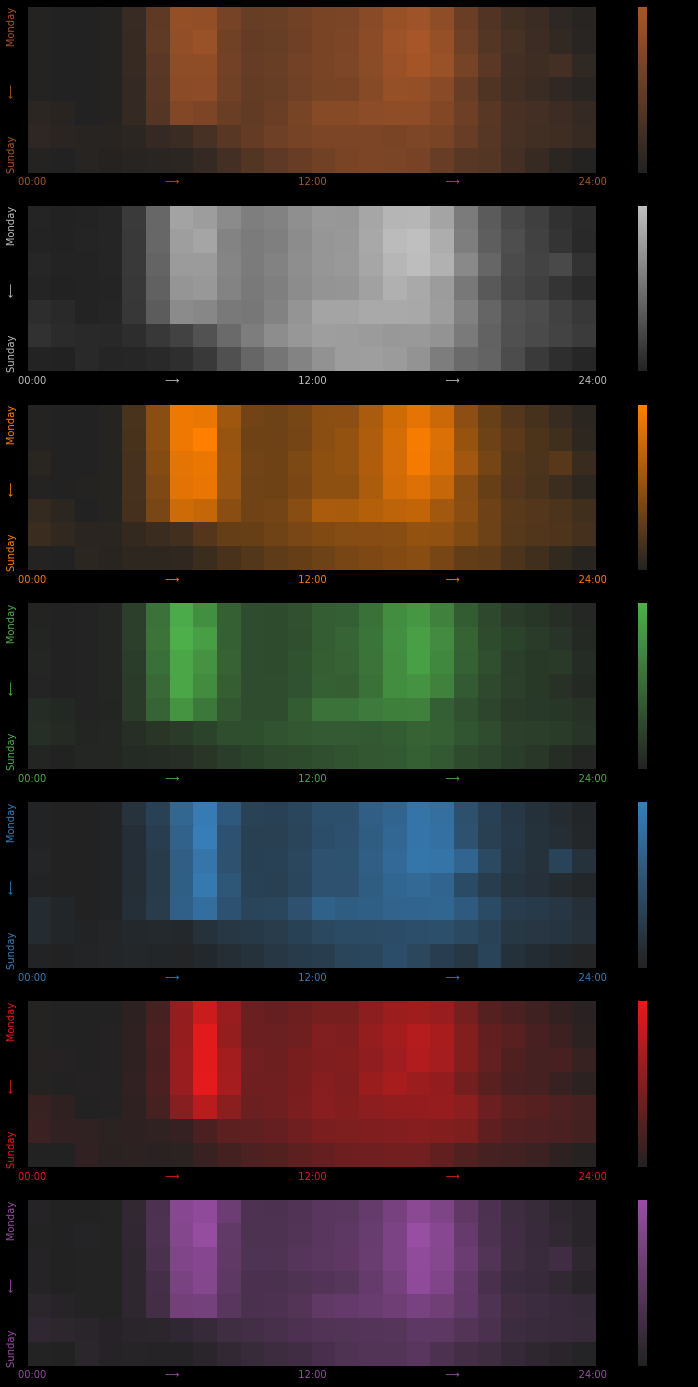

In [31]:
heatmap(True).get_figure().savefig('plots/heatmap_dark.png', transparent=True)

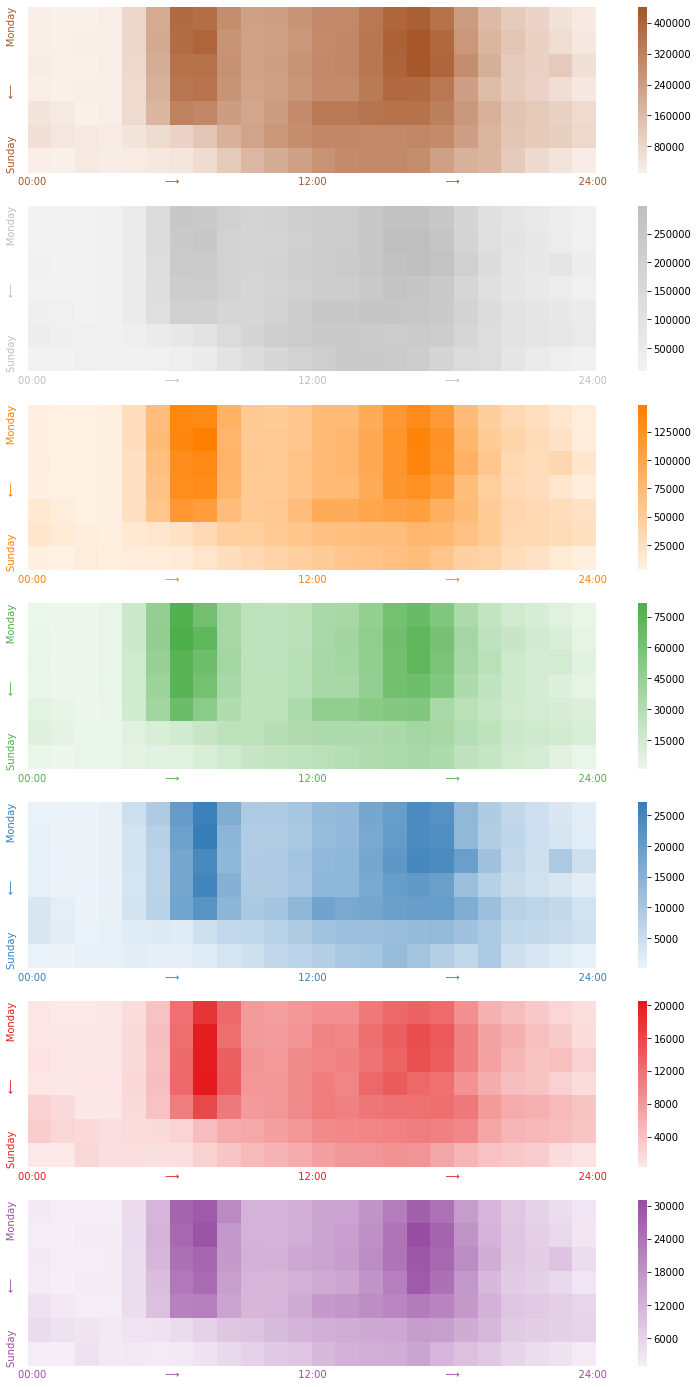

In [29]:
heatmap().get_figure().savefig('plots/heatmap_light.png', transparent=True)